In [30]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import missingno as msn 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

In [13]:
data = pd.read_csv("Titanic-Dataset.csv")
df = data.copy()

In [14]:
def analiz(df):
    ## Genel veri seti bilgileri 
    print(f"Veri boyutu : {df.shape[0]} satır, {df.shape[1]} sütun. \n")
    print("Veri genel bilgileri :\n")
    print(df.info())
    ## kopyalanmış veriler
    duplicates = df.duplicated().sum()
    print(f"\nToplam duplicate kayıt sayısı: {duplicates} \n")
    ## numerik sütunlar
    numCols = df.select_dtypes(include=['int64', 'float64']).columns
    if (len(numCols) > 0):
        print("Sayısal sütunların bilgileri : \n")
        print(df[numCols].describe().T)
    ## kategorik sütunlar 
    cateCol = df.select_dtypes(include=['object', 'category', 'bool']).columns
    if (len(cateCol) > 0):
        for i in cateCol:
            print(df[i].value_counts())
            print(f"Benzersiz değer sayısı : {df[i].nunique(dropna = True)}\n")

    ## eksik değer matrisi
    msn.matrix(df,figsize=(8,4),fontsize=10)
    ## korelasyon matrisi
    if (len(numCols) > 1):
        corr_mat = df[numCols].corr()
        plt.figure(figsize=(8,6))
        sns.heatmap(corr_mat,annot=True, cmap='coolwarm', fmt='.1f')
        plt.title("Korelasyon Matrisi")
        plt.show()
    return

Veri boyutu : 891 satır, 12 sütun. 

Veri genel bilgileri :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Toplam duplicate kayıt sayısı: 0 

Sayısal sütunların bilgileri : 

             count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000

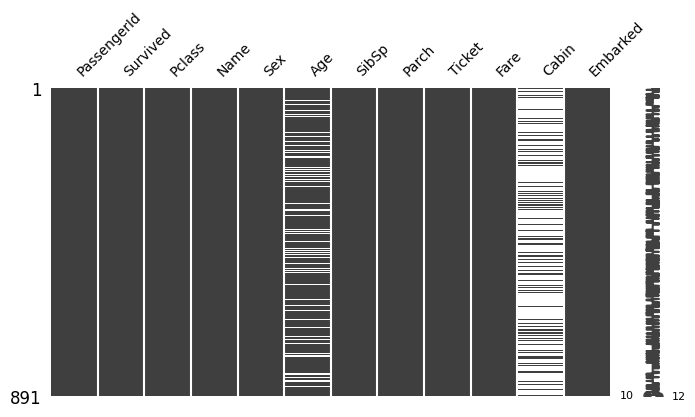

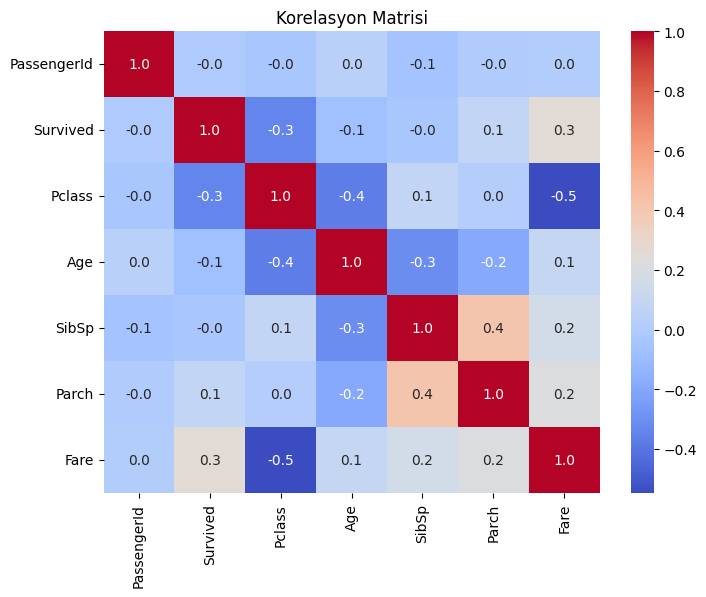

In [15]:
analiz(df)

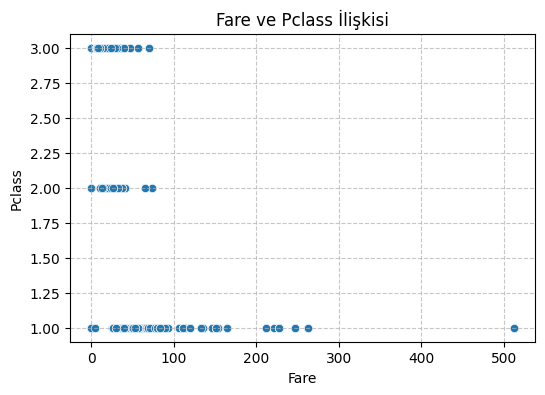

In [16]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df["Fare"], y=df["Pclass"], data=df)
plt.title("Fare ve Pclass İlişkisi")
plt.xlabel("Fare")
plt.ylabel("Pclass")
plt.grid(True, linestyle='--', alpha=0.7)

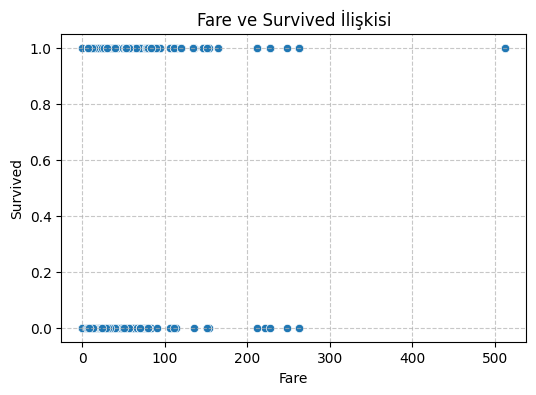

In [37]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df["Fare"], y=df["Survived"], data=df)
plt.title("Fare ve Survived İlişkisi")
plt.xlabel("Fare")
plt.ylabel("Survived")
plt.grid(True, linestyle='--', alpha=0.7)

In [17]:
df.drop(columns=["Embarked","Name","Cabin"],inplace=True)

##### Outlier değerleri ve NaN değerleri ortalama ile doldurma ↓

In [18]:
def outlier_analiz(x_train, x_test):
    numCols = x_train.select_dtypes(include=['int64', 'float64']).columns
    outlier_index_train = {}
    outlier_index_test = {}
    
    for col in numCols:
        q1 = x_train[col].quantile(0.25)
        q3 = x_train[col].quantile(0.75)
        iqr = q3 - q1
        upper = q3 + 1.5 * iqr
        lower = q1 - 1.5 * iqr
        
        # Eğitim seti aykırı değer indeksleri
        train_outliers = x_train[(x_train[col] < lower) | (x_train[col] > upper)].index
        outliers_count = len(train_outliers)
        if outliers_count > 0:
            print(f"Train setinde {col} sütununda {outliers_count} aykırı değer var")
            outlier_index_train[col] = train_outliers
        
        # Sadece tamsayı sütunları için - eğitim seti
        if x_train[col].dtype == 'int64':
            x_train.loc[x_train[col] > upper, col] = int(upper)
            x_train.loc[x_train[col] < lower, col] = int(lower)
        else:
            x_train.loc[x_train[col] > upper, col] = upper
            x_train.loc[x_train[col] < lower, col] = lower
        
        # Test seti aykırı değer indeksleri
        if col in x_test.columns:
            test_outliers = x_test[(x_test[col] < lower) | (x_test[col] > upper)].index
            test_count = len(test_outliers)
            if test_count > 0:
                print(f"Test setinde {col} sütununda {test_count} aykırı değer var")
                outlier_index_test[col] = test_outliers
            
            # Sadece tamsayı sütunları için - test seti
            if x_test[col].dtype == 'int64':
                x_test.loc[x_test[col] > upper, col] = int(upper)
                x_test.loc[x_test[col] < lower, col] = int(lower)
            else:
                x_test.loc[x_test[col] > upper, col] = upper
                x_test.loc[x_test[col] < lower, col] = lower
    
    return outlier_index_train, outlier_index_test

Train setinde Age sütununda 6 aykırı değer var
Test setinde Age sütununda 2 aykırı değer var
Train setinde SibSp sütununda 40 aykırı değer var
Test setinde SibSp sütununda 6 aykırı değer var
Train setinde Parch sütununda 168 aykırı değer var
Test setinde Parch sütununda 45 aykırı değer var
Train setinde Fare sütununda 96 aykırı değer var
Test setinde Fare sütununda 20 aykırı değer var


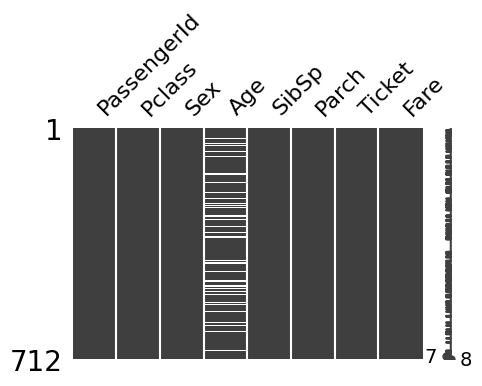

In [19]:
# Veri setinizi bölüyoruz
y = df["Survived"]
X = df.drop(columns="Survived")
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

msn.matrix(x_train,figsize=(5,3))

# numerik sütunlar
numeric_cols = x_train.select_dtypes(include=['int64', 'float64']).columns

outlier_index_train, outlier_index_test = outlier_analiz(x_train.copy(), x_test.copy())

# train setindeki numerik sütunların aykırı değerlerini NaN yapma
for col in numeric_cols:
    if col in outlier_index_train:
        x_train.loc[outlier_index_train[col], col] = np.nan

# test için
for col in numeric_cols:
    if col in outlier_index_test:
        x_test.loc[outlier_index_test[col], col] = np.nan

# SimpleImputer mean ile NaN değerleri doldurma
imputer = SimpleImputer(strategy='mean')
x_train.loc[:, numeric_cols] = imputer.fit_transform(x_train[numeric_cols])
x_test.loc[:, numeric_cols] = imputer.transform(x_test[numeric_cols])

<Axes: >

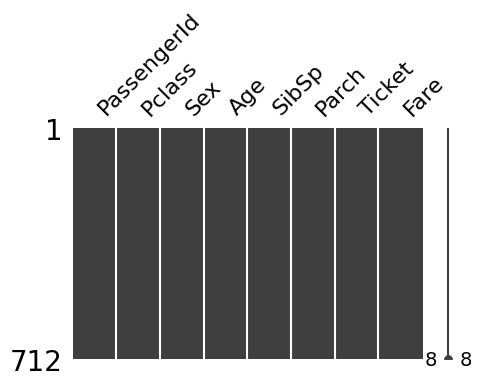

In [20]:
msn.matrix(x_train,figsize=(5,3))

<Axes: >

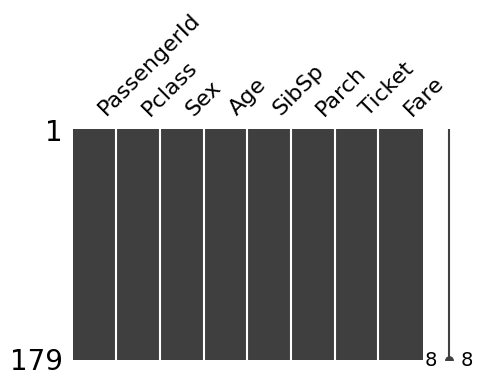

In [21]:
msn.matrix(x_test,figsize=(5,3))

- Bos ve aykırı değerler 'mean' ile dolduruldu.

In [22]:
x_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare
333,334,3,male,16.0,2.0,0.0,345764,18.0000
662,663,1,male,47.0,0.0,0.0,5727,25.5875
382,383,3,male,32.0,0.0,0.0,STON/O 2. 3101293,7.9250
331,332,1,male,45.5,0.0,0.0,113043,28.5000
149,150,2,male,42.0,0.0,0.0,244310,13.0000


In [23]:
x_train.drop(columns=["PassengerId","Ticket"],inplace=True) 
x_test.drop(columns=["PassengerId","Ticket"],inplace=True) 

In [31]:
categorical_cols = ['Sex']
numeric_cols = [col for col in x_train.columns if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

if hasattr(x_train_processed, "toarray"):
    x_train_processed = x_train_processed.toarray()
if hasattr(x_test_processed, "toarray"):
    x_test_processed = x_test_processed.toarray()

le = LabelEncoder()
x_train['Sex'] = le.fit_transform(x_train['Sex'])
x_test['Sex'] = le.transform(x_test['Sex'])

# yeni sütunların isimleri
new_cols = list(numeric_cols)
new_cols.extend([f'Sex_{le.classes_[1]}'])
x_train_processed = pd.DataFrame(x_train_processed, columns=new_cols, index=x_train.index)
x_test_processed = pd.DataFrame(x_test_processed, columns=new_cols, index=x_test.index)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score

models = {
    'Logistic Regression': LogisticRegression(
    penalty=None,              # Ceza türü ('l1', 'l2', 'elasticnet' veya None)
    C=1.0,                     # Regülarizasyon şiddeti (küçük değerler: daha güçlü regülarizasyon)
    solver='lbfgs',            # Optimizasyon algoritması ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')
    max_iter=100,              # Yakınsama için maksimum iterasyon sayısı
    class_weight=None,         # Sınıf ağırlıkları (None, 'balanced' veya sözlük)
    random_state=None,         # Rastgelelik için tohum değeri
    tol=1e-4,                  # Durdurma kriteri için tolerans
    fit_intercept=True,        # Sabit terimin hesaplanıp hesaplanmayacağı
    l1_ratio=None              # Elasticnet karışım parametresi (0 <= l1_ratio <= 1)
),
    'RandomForest': RandomForestClassifier(n_estimators=100,           # Ormandaki ağaç sayısı
    criterion='gini',           # Bölünme kalitesi ölçüsü ('gini' veya 'entropy')
    max_depth=None,             # Ağaçların maksimum derinliği
    min_samples_split=2,        # Bir düğümü bölmek için gereken minimum örnek sayısı
    min_samples_leaf=1,         # Bir yaprak düğümde olması gereken minimum örnek sayısı
    max_features='sqrt',        # Her bölünmede dikkate alınacak özellik sayısı
    bootstrap=True,             # Örneklerin bootstrap ile mi seçileceği
    random_state=None,          # Rastgelelik için tohum değeri
    class_weight=None,          # Sınıf ağırlıkları (None, 'balanced' veya sözlük)
    n_jobs=-1  ),
    'Support Vector Machine': SVC(
    C=1.0,                     # Regülarizasyon parametresi
    kernel='rbf',              # Kernel tipi ('linear', 'poly', 'rbf', 'sigmoid')
    degree=3,                  # Polinom kernel için derece
    gamma='scale',             # Kernel katsayısı ('scale', 'auto' veya float)
    probability=False,         # Olasılık tahminleri etkinleştirme
    class_weight=None,         # Sınıf ağırlıkları (None, 'balanced' veya sözlük)
    random_state=None,         # Rastgelelik için tohum değeri
    cache_size=200,            # Kernel hesaplamaları için bellek önbelleği (MB)
    max_iter=-1                # Maksimum iterasyon sayısı (-1: sınırsız)
)
}

for model_name, model in models.items():
    model.fit(x_train_processed, y_train)
    y_pred = model.predict(x_test_processed)
    
    print(model_name)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')  # veya 'weighted'
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-Score:", f1)
    print(30*"-")

Logistic Regression
Accuracy: 0.8491620111731844
Precision: 0.8306385869565218
Recall: 0.8380800222283968
F1-Score: 0.8340600858369098
------------------------------
RandomForest
Accuracy: 0.8603351955307262
Precision: 0.8453781512605043
Recall: 0.842595165323701
F1-Score: 0.8439515988422778
------------------------------
Support Vector Machine
Accuracy: 0.8659217877094972
Precision: 0.8576979472140762
Recall: 0.8389135871075298
F1-Score: 0.8469649472784269
------------------------------
